In [1]:
from esm.pretrained import ESM3_structure_encoder_v0, ESM3_structure_decoder_v0
from esm.utils.structure.protein_chain import ProteinChain

import torch
import numpy as np

import sys
sys.path.append('/burg/home/jb5005')
import os
import pytorch_lightning as pl

from huggingface_hub import login
from struct_diff.data.flow import interpolate
from struct_diff.data.datamodule import ContinuousStructTokenDataModule
from struct_diff.model.models import TransformerModel
from struct_diff.model.layers import TransformerLayer, positional_encoding, time_encoding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [69]:
decoder = ESM3_structure_decoder_v0(device=device)
encoder = ESM3_structure_encoder_v0(device=device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab = decoder.embed(torch.arange(0, 4100, device=device))

/pmglocal/jb5005/mambaforge/envs/struct_diff/lib/python3.12/site-packages/esm/pretrained.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [3]:
#Full Decode 
def decode(struct_tokens):
    #Add BOS and EOS
    
    BOS_token = torch.tensor([4098], device = device)
    EOS_token = torch.tensor([4097], device = device)

    prepped_tokens = torch.cat([BOS_token, struct_tokens, EOS_token]).unsqueeze(0)
    output =  decoder.decode(prepped_tokens)
    bb_pred = output['bb_pred'].squeeze()
    bb_pred = bb_pred.cpu().detach().numpy()
    temp_chain = ProteinChain.from_backbone_atom_coordinates(bb_pred)
    return temp_chain


In [57]:
def convert_continuous_to_discrete_token(x1):
    """
    Maps backwards from the continuous token embedding to the discrete version
    Computes the Euclidean distance between the continuous token and all discrete tokens, 
    then selects discrete with the smallest distance

    args: x1 [BxLx1280]
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    decoder = ESM3_structure_decoder_v0(device=device)
    vocab = decoder.embed(torch.arange(0, 4100, device=device))  # [4100, 1280]
    
    # Ensure vocab matches the last dimension of x1
    if vocab.size(-1) != x1.size(-1):
        raise ValueError("Mismatch in embedding dimensions between x1 and vocab.")
    
    # Compute distances [B, L, 4100]
    distances = torch.cdist(x1, vocab, p=2)
    
    # Get the closest discrete tokens
    closest_indices = distances.argmin(dim=-1)  # [B, L]
    min_distances = torch.gather(distances, -1, closest_indices.unsqueeze(-1)).squeeze(-1)  # [B, L]

    distances_for_second_min = distances.clone()
    distances_for_second_min.scatter_(-1, closest_indices.unsqueeze(-1), float('inf'))
    
    # Find the second closest token
    second_closest_indices = distances_for_second_min.argmin(dim=-1) # [B, L]
    second_min_distances = torch.gather(distances, -1, second_closest_indices.unsqueeze(-1)).squeeze(-1) # [B, L]

    
    return closest_indices.squeeze(), min_distances, second_min_distances

In [58]:
model = TransformerModel()
checkpoint = torch.load("/pmglocal/jb5005/wandb_files/struct_diff_v0/50lsjiz6/checkpoints/copy.ckpt")
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

/tmp/ipykernel_4107437/1077339200.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/pmglocal/jb5005/wandb_files/struct_diff_v0/50lsjiz6/checkpoin

In [ ]:
def add_special_token_columns(tensor):
    bos_col = torch.full((tensor.shape[0], 1), 4098, device=tensor.device, dtype=tensor.dtype)
    eos_col = torch.full((tensor.shape[0], 1), 4097, device=tensor.device, dtype=tensor.dtype)
    
    return torch.cat([bos_col, tensor, eos_col], dim=1)

In [105]:
x_orig = 0.001* torch.randn([100,128,1280], device = device)
x = x_orig
num_steps = 100
# model.load_from_checkpoint()
model.eval()
with torch.no_grad():
    for i in range(num_steps):
        t = i/num_steps

        if i != 0:
            #inject noise
            noise = 0.001* torch.randn([100,128,1280], device = device)
            x = t * x + (1-t) * noise
        x += 1/num_steps * model(x, t)

        if t<0.5:
            # Convert continuous to discrete tokens
            struct_tokens, distances, second_distances = convert_continuous_to_discrete_token(x)
            # Ensure struct_tokens is 1D
            struct_tokens = struct_tokens.squeeze()

            # Create special tokens
            BOS_token = torch.tensor([4098], device=device).unsqueeze(0)
            EOS_token = torch.tensor([4097], device=device).unsqueeze(0)

            # Concatenate tokens with correct dimensions
            prepped_tokens = struct_tokens

            # Decode the prepared tokens
            x = decoder.embed(prepped_tokens)

/pmglocal/jb5005/mambaforge/envs/struct_diff/lib/python3.12/site-packages/esm/pretrained.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [81]:
def add_special_token_columns(tensor):
    bos_col = torch.full((tensor.shape[0], 1), 4098, device=tensor.device, dtype=tensor.dtype)
    eos_col = torch.full((tensor.shape[0], 1), 4097, device=tensor.device, dtype=tensor.dtype)
    
    return torch.cat([bos_col, tensor, eos_col], dim=1)

add_special_token_columns(struct_tokens)

tensor([[4098,  264, 3274,  ..., 3087,  330, 4097],
        [4098, 3722,  824,  ..., 1249, 1450, 4097],
        [4098, 1450, 2874,  ...,  137, 3961, 4097],
        ...,
        [4098,  264, 2056,  ..., 1476, 1184, 4097],
        [4098, 2056,  588,  ..., 1450,  264, 4097],
        [4098, 3657, 2048,  ..., 3040, 1450, 4097]], device='cuda:0')

In [85]:
struct_tokens[0]

tensor([3657, 3814, 1858, 2048, 1450, 2048,  137, 3657, 3961, 2074, 1957,  824,
        1348, 3423, 3047, 1722,  987, 1265, 4052,   25, 4058, 1499, 4058, 2082,
        2048, 3961, 1968, 2874, 2074, 1566,  824,  123, 1898,  169, 3954, 1455,
        1947, 2542, 2874,  987,  321,  137, 2018, 2018, 1898,  987, 1898, 2056,
        2056, 3423, 1858,  987, 3553,  677, 1450, 3150, 2745,  123, 1138, 3961,
        3566, 3160, 3087, 3654, 2048, 2048, 2018,  824,  509,  123, 2048,  264,
        1898,  824, 1450, 2622, 1450,  677, 3647,  169,  987,  824, 1722,  123,
        2082, 4052, 2048, 1476, 3397,  264,  137,  824,  137, 3047, 1265, 1957,
        3820,  578,  824, 3533, 3653, 1483, 2003,  578, 2048, 3533,  123, 1348,
        1265, 3722, 2082,  477, 3056, 2396, 3047, 2396,  509, 2048, 1722, 1476,
        1265, 3423,  123, 2048, 1957, 2622, 3961, 1476], device='cuda:0')

In [106]:
struct_tokens, distances, second_distances = convert_continuous_to_discrete_token(x)
first_protein_chain = decode(struct_tokens[2])

# print(torch.mean(distances))

first_protein_chain.to_pdb("third_protein.pdb")

<Axes: ylabel='Count'>

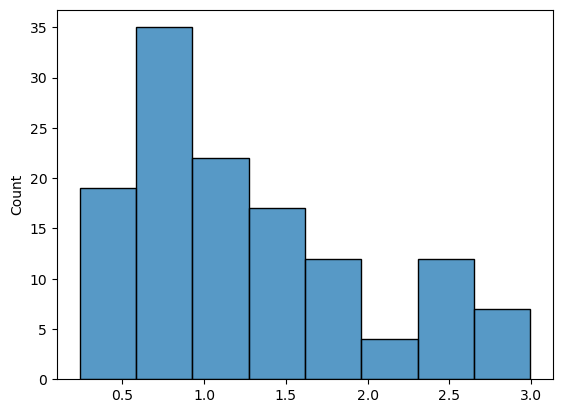

In [61]:
sns.histplot(distances[2].detach().cpu().numpy())

(0.0, 5.0)

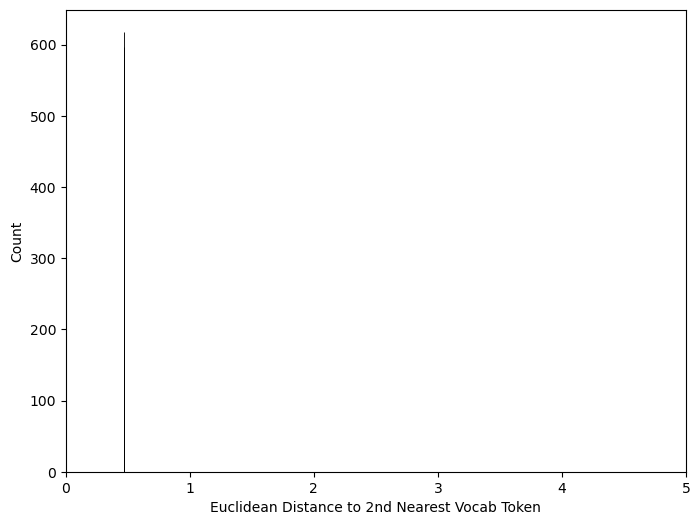

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.histplot(distances.flatten().cpu().detach().numpy())
plt.xlabel("Euclidean Distance to 2nd Nearest Vocab Token")
plt.xlim(0,5)

In [10]:
convert_continuous_to_discrete_token(x)

/pmglocal/jb5005/mambaforge/envs/struct_diff/lib/python3.12/site-packages/esm/pretrained.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


(tensor([[2874, 3961, 2048,  ..., 2605, 2585, 3961],
         [3961, 1450,  987,  ..., 3961, 1197, 2056],
         [1184,  264, 3961,  ..., 2056, 2000, 2048],
         ...,
         [2048, 1197, 2082,  ..., 1156, 2048,  321],
         [1476, 3961, 2056,  ..., 2000,  123, 3524],
         [1898, 4099, 2056,  ..., 2048, 1442, 2048]], device='cuda:0'),
 tensor([[0.4328, 1.1549, 0.6283,  ..., 2.2155, 1.4120, 0.8643],
         [1.5256, 1.2791, 0.9665,  ..., 0.9922, 0.7320, 0.9278],
         [2.7966, 0.9910, 1.3428,  ..., 1.7935, 2.9162, 0.9362],
         ...,
         [1.0351, 0.7938, 0.3352,  ..., 2.3184, 0.9722, 1.2021],
         [1.7755, 1.9993, 0.7860,  ..., 2.3077, 1.4263, 2.3758],
         [2.5942, 2.5468, 1.1889,  ..., 0.8952, 2.7368, 1.1316]],
        device='cuda:0', grad_fn=<SqueezeBackward1>))

In [12]:
torch.sqrt(torch.sum((vocab[2083]-vocab[332])**2))

tensor(3.5823, device='cuda:0', grad_fn=<SqrtBackward0>)

In [13]:
convert_continuous_to_discrete_token(x)

(tensor([[2874, 3961, 2048,  ..., 2605, 2585, 3961],
         [3961, 1450,  987,  ..., 3961, 1197, 2056],
         [1184,  264, 3961,  ..., 2056, 2000, 2048],
         ...,
         [2048, 1197, 2082,  ..., 1156, 2048,  321],
         [1476, 3961, 2056,  ..., 2000,  123, 3524],
         [1898, 4099, 2056,  ..., 2048, 1442, 2048]], device='cuda:0'),
 tensor([[0.4328, 1.1549, 0.6283,  ..., 2.2155, 1.4120, 0.8643],
         [1.5256, 1.2791, 0.9665,  ..., 0.9922, 0.7320, 0.9278],
         [2.7966, 0.9910, 1.3428,  ..., 1.7935, 2.9162, 0.9362],
         ...,
         [1.0351, 0.7938, 0.3352,  ..., 2.3184, 0.9722, 1.2021],
         [1.7755, 1.9993, 0.7860,  ..., 2.3077, 1.4263, 2.3758],
         [2.5942, 2.5468, 1.1889,  ..., 0.8952, 2.7368, 1.1316]],
        device='cuda:0', grad_fn=<SqueezeBackward1>))

In [14]:
def compute_row_distances(tensor):
    """
    Compute the Euclidean distance between each pair of rows in a 2D tensor.
    
    Args:
        tensor (torch.Tensor): A 2D tensor of shape [N, D].
        
    Returns:
        list: A list of distances between each pair of rows.
    """
    # Compute pairwise Euclidean distances
    distances = torch.cdist(tensor, tensor, p=2)  # Shape [N, N]
    
    # Flatten the distances into a list
    distance_list = distances.view(-1).tolist()
    
    return distance_list

# Example
tensor = torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float32)
result = compute_row_distances(tensor)
print(result)

[0.0, 2.8284270763397217, 5.656854152679443, 2.8284270763397217, 0.0, 2.8284270763397217, 5.656854152679443, 2.8284270763397217, 0.0]


In [15]:
torch.cdist(vocab, vocab, p=2)

tensor([[5.9402e-03, 3.4917e+00, 3.6334e+00,  ..., 3.4333e+00, 3.2553e+00,
         2.5575e+00],
        [3.4917e+00, 5.2589e-03, 3.5302e+00,  ..., 3.4466e+00, 3.3473e+00,
         2.5226e+00],
        [3.6334e+00, 3.5302e+00, 6.0199e-03,  ..., 3.6056e+00, 3.4842e+00,
         2.6727e+00],
        ...,
        [3.4333e+00, 3.4466e+00, 3.6056e+00,  ..., 4.6834e-03, 3.1589e+00,
         2.4357e+00],
        [3.2553e+00, 3.3473e+00, 3.4842e+00,  ..., 3.1589e+00, 5.2589e-03,
         2.2680e+00],
        [2.5575e+00, 2.5226e+00, 2.6727e+00,  ..., 2.4357e+00, 2.2680e+00,
         1.0066e-03]], device='cuda:0', grad_fn=<ViewBackward0>)

In [31]:
dist_list = []
all_vocab_distances = torch.cdist(vocab, vocab, p=2)
offset = torch.eye(len(vocab)).to(device) * 1e6
all_vocab_distances += offset
for i in range(len(vocab)):
    distance = torch.min(all_vocab_distances[i])
    distance = torch.tensor([distance])
    dist_list += distance.tolist()

In [32]:
len(dist_list)

4100

(0.0, 5.0)

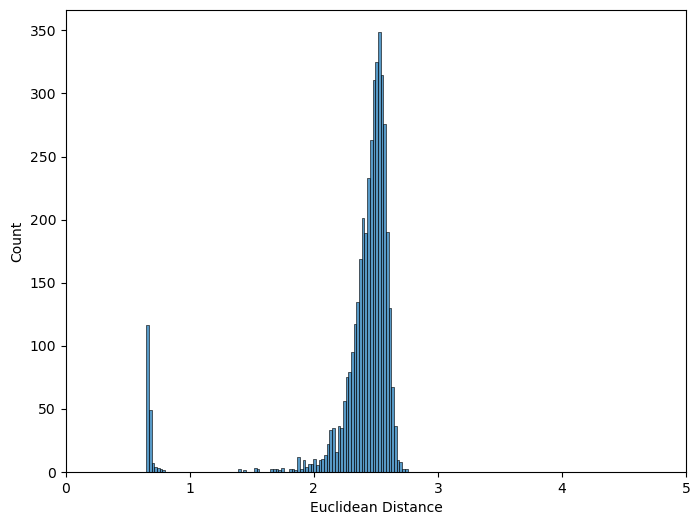

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.histplot(dist_list)
plt.xlabel("Euclidean Distance")
plt.xlim(0, 5)
